In [1]:
%matplotlib inline
import pylab as pl

# for display within notebook
pl.rcParams['figure.facecolor'] = 'w'

from spectral_cube import SpectralCube
from astropy import units as u

# Debuggy loading: this approach needed b/c the code isn't properly packaged
import imp
import sys
sys.path.append('/orange/adamginsburg/ALMA_IMF/reduction/analysis')
import imstats
imp.reload(imstats)
from imstats import get_psf_secondpeak

INFO: G008.67 B3 [unknown]
INFO: first_sidelobe_ind=31, first_min_ind = 30 [imstats]


INFO: G010.62 B3 [unknown]
INFO: first_sidelobe_ind=22, first_min_ind = 20 [imstats]


INFO: G012.80 B3 [unknown]
INFO: radial extent = 19.230769230770658,  r_max_sidelobe = 114.65092742931762, ******** [imstats]


INFO: G327.29 B3 [unknown]
INFO: first_sidelobe_ind=44, first_min_ind = 43 [imstats]


INFO: G328.25 B3 [unknown]
INFO: radial extent = 62.500000000001414,  r_max_sidelobe = 68.24182755909457, ******** [imstats]


INFO: G333.60 B3 [unknown]
INFO: radial extent = 62.500000000001414,  r_max_sidelobe = 94.235879307575, ******** [imstats]


INFO: G337.92 B3 [unknown]
INFO: first_sidelobe_ind=22, first_min_ind = 21 [imstats]


INFO: G338.93 B3 [unknown]
INFO: first_sidelobe_ind=21, first_min_ind = 20 [imstats]


INFO: G351.77 B3 [unknown]
INFO: radial extent = 19.230769230770658,  r_max_sidelobe = 112.3551002907385, ******** [imstats]


INFO: G353.41 B3 [unknown]
INFO: radial extent = 19.230769230770658,  r_max_sidelobe = 114.04055121514233, ******** [imstats]


INFO: W43-MM1 B3 [unknown]
INFO: first_sidelobe_ind=35, first_min_ind = 34 [imstats]


INFO: W43-MM2 B3 [unknown]
INFO: radial extent = 62.500000000001414,  r_max_sidelobe = 118.83024148024747, ******** [imstats]


INFO: W43-MM3 B3 [unknown]
INFO: radial extent = 62.500000000001414,  r_max_sidelobe = 135.02017907499763, ******** [imstats]


INFO: W51-E B3 [unknown]
INFO: first_sidelobe_ind=22, first_min_ind = 18 [imstats]


INFO: W51-IRS2 B3 [unknown]
INFO: first_sidelobe_ind=13, first_min_ind = 12 [imstats]


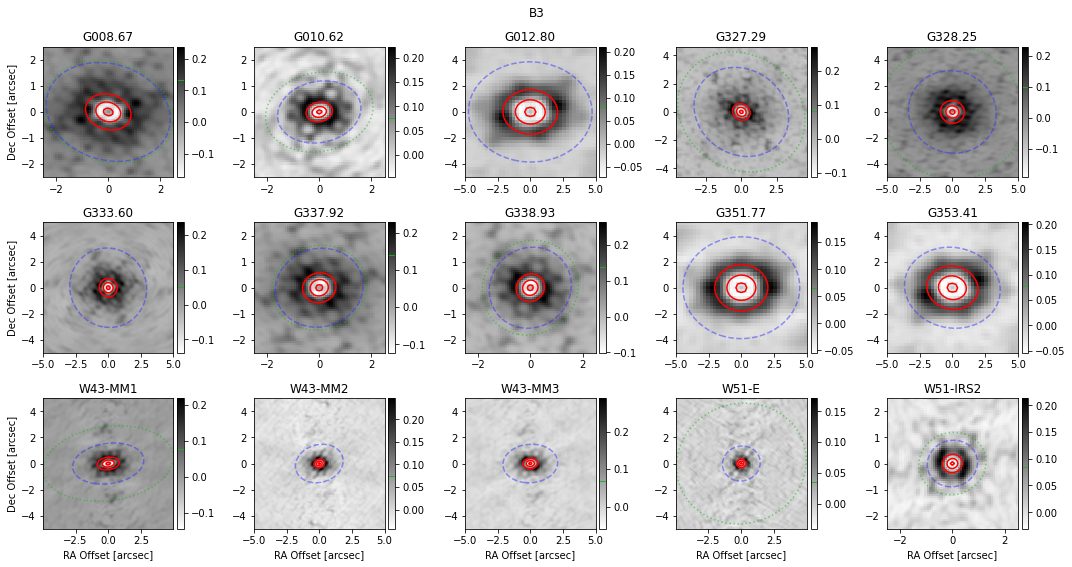

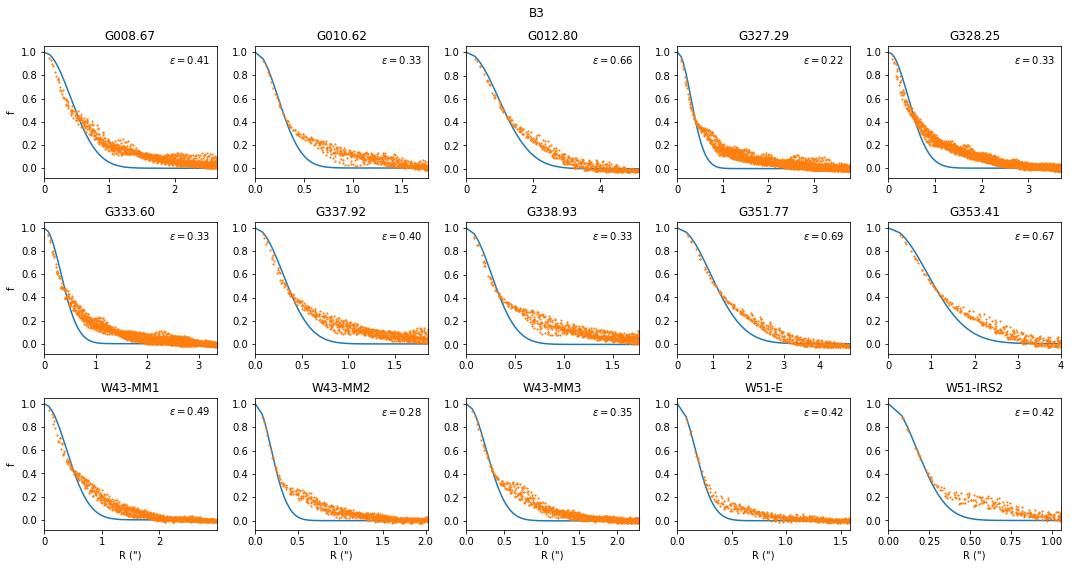

In [4]:
import glob
import os
from astropy import units as u
from astropy import log

from spectral_cube import SpectralCube

from pathlib import Path

from imstats import get_psf_secondpeak

import pylab as pl

releasepath = Path('/orange/adamginsburg/ALMA_IMF/figures/')
datapath = Path('/orange/adamginsburg/ALMA_IMF/2017.1.01355.L/RestructuredImagingResults/')


pl.close('all')


for jj, (band, itgl) in enumerate((('B3', 'n2hp'),)):# ('B6', 'sio'), ('B3','12M_spw1'),)):
    fig = pl.figure(jj, figsize=(15, 8), facecolor='w')
    fig.clf()
    fig.suptitle(band)

    fig2 = pl.figure(jj+2, figsize=(15, 8), facecolor='w')
    fig2.clf()
    fig2.suptitle(band)

    for ii, field in enumerate(sorted("G008.67 G337.92 W43-MM3 G328.25 G351.77 G012.80 G327.29 W43-MM1 G010.62 W51-IRS2 W43-MM2 G333.60 G338.93 W51-E G353.41".split())):


        imtype = 'linecubes_12m'

        itpath = datapath / field / band / imtype
        suffix = 'psf'

        globstr = (f"{field}*_{band}_*{itgl}*.{suffix}")

        files = glob.glob(str(itpath / globstr))
        if len(files) > 1:
            raise ValueError("Too many files")
        elif len(files) == 0:
            print(f"Skipped field {field}")
            continue
            if field == 'W43-MM1' and band == 'B6':
                raise ValueError("W43-MM1 is still missing! (but it should exist now)")
            else:
                raise ValueError("Not enough files")

        psffn = files[0]

        pl.figure(fig)
        ax = fig.add_subplot(3, 5, ii+1)
        ax.set_title(field)
        
        cube = SpectralCube.read(psffn, format='casa_image')
        specslice=slice(cube.shape[0]//2, cube.shape[0]//2+1)
        
        log.info(f"{field} {band}")
        (psf_secondpeak, psf_secondpeak_loc, psf_sidelobe1_fraction, epsilon, firstnull,
         r_sidelobe, (rr, pixscale, cutout, beam, fullbeam, view, bmfit_residual)) = \
                get_psf_secondpeak(psffn, show_image=True, min_radial_extent=2.5*u.arcsec,
                           max_radial_extent=5*u.arcsec,
                                   specslice=specslice
                          )

        if ii not in (0, 5, 10):
            ax.set_ylabel("")
        if ii < 10:
            ax.set_xlabel("")

        pl.figure(fig2)
        ax2 = fig2.add_subplot(3, 5, ii+1)
        ax2.set_title(field)
        rr_inds = rr.ravel().argsort()
        sorted_synth = (fullbeam.array.ravel()/fullbeam.array.max())[rr_inds]
        pixscale = pixscale.to(u.arcsec)
        ax2.plot(pixscale.value*rr.ravel()[rr_inds], sorted_synth, '-', label='Synth')
        ax2.plot(pixscale.value*rr.ravel(), cutout.ravel()/cutout.max(), '.', label='Dirty', alpha=0.75, markersize=2)
        ax2.set_xlim(0, firstnull.value*1.1)# rr[view].max())
        ax2.text(firstnull.value*0.8, 0.9, f'$\epsilon={epsilon:0.2f}$')

        if ii not in (0, 5, 10):
            ax2.set_ylabel("")
        else:
            ax2.set_ylabel("f")
        if ii < 10:
            ax2.set_xlabel("")
        else:
            ax2.set_xlabel("R (\")")



    pl.figure(fig)
    pl.subplots_adjust(wspace=0.32)
    pl.tight_layout()
    fig.savefig(releasepath / f'{band}_{itgl}_psfs.png', bbox_inches='tight', dpi=300)
    fig.savefig(releasepath / f'{band}_{itgl}_psfs.pdf', bbox_inches='tight')

    pl.figure(fig2)
    pl.subplots_adjust(wspace=0.32)
    pl.tight_layout()
    fig2.savefig(releasepath / f'{band}_{itgl}_psf_profiles.png', bbox_inches='tight', dpi=300)
    fig2.savefig(releasepath / f'{band}_{itgl}_psf_profiles.pdf', bbox_inches='tight')
